In [1]:
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint

import json

import os

from unsloth import FastLanguageModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 10-01 08:35:44 [__init__.py:244] Automatically detected platform cuda.


In [2]:
def load_json(path:str, filename:str):
    with open(os.path.join(path, filename), mode="r", encoding="utf-8") as f:
        return json.load(f)
    
def format_example(example:dict, system_message):
        formatted_example = [
            {"role": "assistant", "content": system_message},
            {"role": "user", "content": example["input"]},
            {"role": "assistant", "content": json.dumps(example["output"])}
        ]
        return formatted_example

In [3]:
system_messages = {
    "domain-name":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all domain names referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe domain names.
                    To describe a domain name you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no domain names are identified return a json with an empty list "objects".
                    Identify all domain names in the folowing CTI report: """,

    "hostname":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all hostnames referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe hostnames.
                    To describe a hostname you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no hostnames are identified return a json with an empty list "objects".
                    Identify all hostnames in the folowing CTI report: """,

    "url":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all URLs referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe URLs.
                    To describe a URL you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no URLs are identified return a json with an empty list "objects".
                    Identify all URLs in the folowing CTI report: """,

    "email-addr":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all email addresses referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe email addresses.
                    To describe an email address you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no email addresses are identified return a json with an empty list "objects".
                    Identify all email addresses in the folowing CTI report: """,

    "ipv4-addr":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all ipv4-addresses referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe ipv4-addresses.
                    To describe an ipv4-address you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no ipv4-addresses are identified return a json with an empty list "objects".
                    Identify all ipv4-addresses in the folowing CTI report: """,

    "cryptocurrency-wallet":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all cryptocurrency-wallets referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe cryptocurrency-wallets.
                    To describe a cryptocurrency-wallet you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no cryptocurrency-wallet are identified return a json with an empty list "objects".
                    Identify all cryptocurrency-wallet in the folowing CTI report: """,

    "indicator":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all indicators referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe indicators.
                    To describe an indicator you should provide the fields id, type, name, description: Optional, indicator_types: Optional[list], pattern: str, pattern_type: Literal["stix", "snort", "yara"].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no indicators are identified return a json with an empty list "objects".
                    Identify all indicators in the folowing CTI report: """, 

    "file":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all files referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe files.
                    To describe a file you should provide the fields id, type, name[Optional], hashes: dict, size[Optional], mime_type[Optional].
                    Instead of using UUID in the id field, use the rule type--hashes for generating ids.
                    If no files are identified return a json with an empty list "objects".
                    Identify all files in the folowing CTI report: """,  

    "attack-pattern":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all attack-patterns referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe attack-patterns.
                    To describe an attack-pattern you should provide the fields id, type, name, description[Optional], aliases[Optional].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no attack-patterns are identified return a json with an empty list "objects".
                    Identify all attack-patterns in the folowing CTI report: """, 

    "identity":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all identities referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe identities.
                    To describe an identity you should provide the fields id, type, name, description[Optional].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no identities are identified return a json with an empty list "objects".
                    Identify all identities in the folowing CTI report: """, 

    "malware":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all malwares referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe malwares.
                    To describe a malware you should provide the fields id, type, name and is_family.
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    For example, an output in which the malware RandomMalware is identified and is not family
                    of some other malware should be like this:
                    {
                        "objects": [
                            {
                                "id": "malware--RandomMalware",
                                "type": "malware",
                                "name": "RandomMalware",
                                "is_family": false
                            }
                        ]
                    }
                    
                    If no malwares are identified return a json with an empty list "objects".
                    Identify all malwares in the folowing CTI report: """, 

    "location":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all locations referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe locations.
                    To describe a location you should provide the fields id, type, name, country, description[Optional], latitude[Optional], longtitude[Optional], city[Optional].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no locations are identified return a json with an empty list "objects".
                    Identify all locations in the folowing CTI report: """, 

    "vulnerability":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all vulnerabilities referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe vulnerabilities.
                    To describe a vulnerability you should provide the fields id, type, name, description[Optional].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no vulnerabilities are identified return a json with an empty list "objects".
                    Identify all vulnerabilities in the folowing CTI report: """,

    "intrusion-set":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all intrusion-sets referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe intrusion-sets.
                    To describe an intrusion-set you should provide the fields id, type, name, description[Optional], aliases[Optional], goals[Optional], resource_level[Optional], primary_motivation[Optional], secondary_motivation[Optional].
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    If no intrusion-sets are identified return a json with an empty list "objects".
                    Identify all intrusion-sets in the folowing CTI report: """,

}

In [19]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/home/deleftheriou/cti-model-training/Llama-3.1-8B-Malware-Expert-r64-a128-nRO/checkpoint-347",# "meta-llama/Llama-3.1-8B-Instruct",
    fast_inference = False,
    load_in_4bit = False,
    max_seq_length = None,
    gpu_memory_utilization = 0.8
)

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.53.0. vLLM: 0.9.1.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from transformers import TextStreamer

#FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

def format_input_prompt(system_message, user_input):
    formatted_input = [
        {"role": "assistant", "content": system_message},
        {"role": "user", "content": user_input}
    ]
    return formatted_input

def format_validation_example_for_inference(example):
    return example.split("<|start_header_id|>user<|end_header_id|>")[1].split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")[0]

def inference(model, system_message, user_input, max_new_tokens=None, **kwargs):
    input_ids = tokenizer.apply_chat_template(
        format_input_prompt(system_message, user_input),
        add_generation_prompt=True,
        return_tensors = "pt").to("cuda")
    if not max_new_tokens:
        max_new_tokens = model.config.max_position_embeddings - input_ids.shape[-1]
    model.generate(input_ids, streamer = text_streamer, max_new_tokens=max_new_tokens, **kwargs)

In [6]:
for name, param in model.named_parameters():
    if name in ["base_model.model.lm_head.modules_to_save.default.weight", "base_model.model.model.embed_tokens.modules_to_save.default.weight"]:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1218445312


In [7]:
train_path = "/mnt/data/openCTI/splitted-io-pairs/train"
validation_path = "/mnt/data/openCTI/splitted-io-pairs/validation"

In [8]:
formatted_train_list = []
formatted_eval_list = []
include_cti_type = ["malware"]

for file in os.listdir(train_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:#if cti_type in ["relationship", "report"]:
        continue
    example = load_json(train_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_train_list.append(formatted_example)

for file in os.listdir(validation_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:#if cti_type in ["relationship", "report"]:
        continue
    example = load_json(validation_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_eval_list.append(formatted_example)

In [9]:
# formatted_train_list = formatted_train_list[:5]
# formatted_eval_list = formatted_eval_list[:2]

In [9]:
import datasets

# Add template of the model in examples
templated_train_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_train_list]
templated_eval_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_eval_list]
# Create hf seperated datasets
hf_train = datasets.Dataset.from_list([dict(text=ex) for ex in templated_train_list])
hf_eval = datasets.Dataset.from_list([dict(text=ex) for ex in templated_eval_list])
# Create a hf dataset dict
dataset = datasets.DatasetDict({"train":hf_train, "eval":hf_eval})
# Filter dataset
if config["filter_dataset"]:
    if not config["filter_threshold"]:
        config["filter_threshold"] = tokenizer.model_max_length
    dataset = dataset.filter(lambda x: len(tokenizer.encode(x["text"])) <= config["filter_threshold"],
                             num_proc=num_proc)

Filter (num_proc=30):   0%|          | 0/1858 [00:00<?, ? examples/s]

Filter (num_proc=30):   0%|          | 0/301 [00:00<?, ? examples/s]

In [11]:
print(dataset["train"]["text"][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all malwares referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe malwares.
                    To describe a malware you should provide the fields id, type, name and is_family.
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    For example, an output in which the malware RandomMalware is identified and is not family
                    of some other malware should be like this:
                    {
                        "objects": [
                            {
                                "id": "malware-

In [12]:
print(format_validation_example_for_inference(dataset["train"]["text"][0]))



External reference URL: https://www.fortinet.com/blog/threat-research/new-midgedropper-variant

CTI REPORT

# New MidgeDropper Variant

Affected Platforms: Windows

Impacted Users: Windows users

Impact: Potential to deploy additional malware for additional purposes

Severity Level: Medium

One of the most exciting aspects of malware analysis is coming across a family that is new or rare to the reversing community. Determining the function of the malware, who created it, and the reasons behind it become a mystery to solve. The previously unseen dropper variant we recently found, named MidgeDropper, has a complex infection chain that includes code obfuscation and sideloading, making it an interesting use case. Although we couldn’t obtain the final payload, this blog will still explore what makes this dropper tick.

## Initial Infection Vector

The initial infection vector was not available to FortiGuard Labs at the time of our investigation. However, we strongly suspect it to be a phi

In [13]:
system_message = system_messages["malware"]
user_input = format_validation_example_for_inference(dataset["train"]["text"][0])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=None,
          temperature=0.7,
          top_p=0.6,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
LlamaForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.


Based on the given CTI reports, I've identified several malwares. Here's the JSON response with the list of malwares:

```json
{
    "objects":
    [
        {
            "id":"malware-family--MidgeDropping",
            "type":"malicious software",
            'name': "Midge Dropping",
            is_family:true
        },
        {
          "id":"+malware-name--ObfuscatedFiles",
          "type":"",
          'name':"Obfuscated Files",
          is_family:false
        }
    ]
}
```

Here's my reasoning:

1. **Midge Dopping**: From both CTI Reports, we know that there is a malware family known as `MidgeDrop`. So, I added it to the list.

2. **Obfuscated files**: From the second CTI Report, we see that there are indicators of compromise mentioning data obfuscations (`T1001`, `T1027`). Therefore, I assumed that there might be a malware associated with these indicators. I named it `Obfuscatedfiles` as it seems like a general term for such kind of malware. 

Note that there may be othe

In [14]:
config["lora_parameters"]["r"] = 64
config["lora_parameters"]["lora_alpha"] = 128
pprint(config["lora_parameters"])

{'bias': 'none',
 'loftq_config': 'None',
 'lora_alpha': 128,
 'lora_dropout': 0,
 'r': 64,
 'target_modules': ['q_proj',
                    'k_proj',
                    'v_proj',
                    'o_proj',
                    'gate_proj',
                    'up_proj',
                    'down_proj',
                    'lm_head',
                    'embed_tokens'],
 'use_gradient_checkpointing': 'unsloth',
 'use_rslora': True}


In [15]:
# Add LoRA weights
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [10]:
_train_on_responses_only_bool = False
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [11]:
config["training_arguments"]["output_dir"] = "Llama-3.1-8B-Malware-Expert-r64-a128-nRO"
config["training_arguments"]["seed"] = 4321
config["lr_scheduler_type"] = "cosine"

In [12]:
# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = num_proc,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1858 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/301 [00:00<?, ? examples/s]

In [13]:
# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = config["instruction_part"],
        response_part = config["response_part"]
    )

In [14]:
config["early_stopping_patience"] = False

if config["early_stopping_patience"]:
    from transformers import EarlyStoppingCallback
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience = config["early_stopping_patience"])
    trainer.add_callback(early_stopping_callback)

In [15]:
# Start training
trainer_stats = unsloth_train(trainer, resume_from_checkpoint = True)

Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for embed_tokens.
Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for lm_head.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,858 | Num Epochs = 3 | Total steps = 351
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 1,218,445,312/9,248,706,560 (13.17% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
331,1.260200,1.342687
332,1.384600,1.342683
333,1.150500,1.342655
334,1.408500,1.342655
335,1.331100,1.342658
336,1.309900,1.342667
337,1.272800,1.342654
338,1.399100,1.342641
339,1.358100,1.342655
340,1.209000,1.342656


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


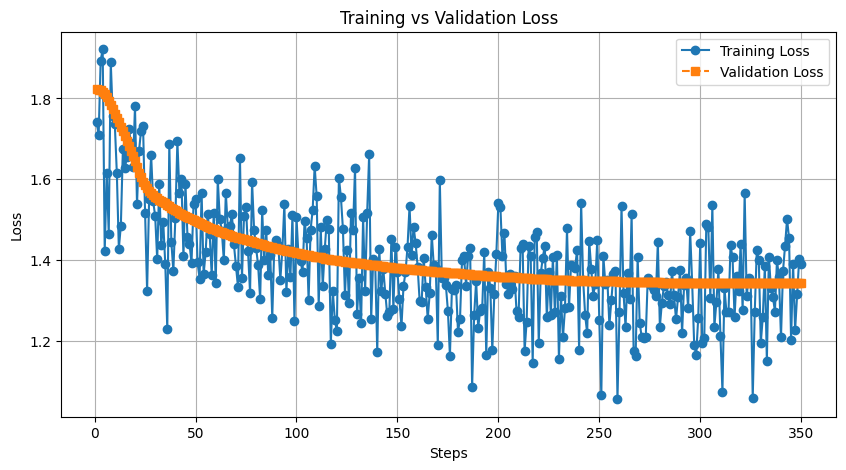

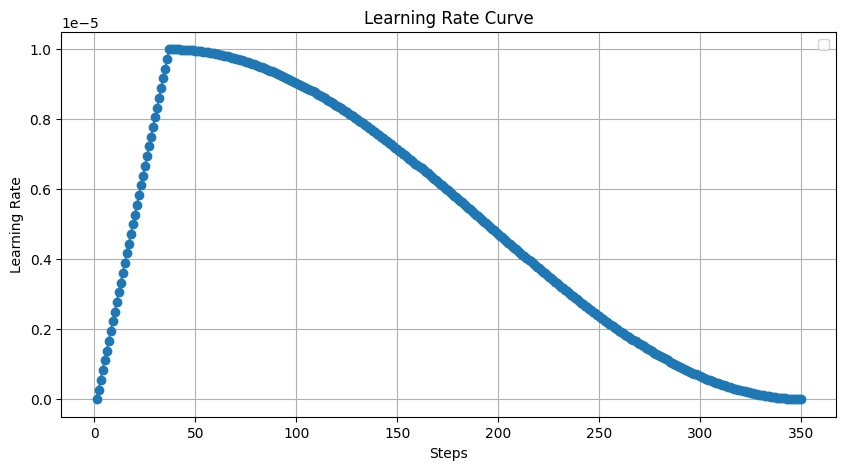

In [16]:
save_log_history(trainer)

In [23]:
system_message = system_messages["malware"]
user_input = format_validation_example_for_inference(dataset["eval"]["text"][50])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=None,
          temperature=0.7,
          top_p=0.6,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

{"objects": [{"id": "-malware-Nitrogen-", "type': malware', "name': 'Nitrogen', "is_familly": false}, {"id": '-malware-BlackCat_ALPHV-', "type' : malwarie', "nane' : "BlackCat ALPHV", "is familly": False}]}


In [32]:
print(json.dumps("""{"objects": [{"id": "-malware-Nitrogen-", "type':": "object", "name':": ": Nitrogen", "is family": false}, {"id": ":malware-BlackCat(ALPHV)-", "type'": " object", " name':": : BlackCat(AL PHV)", "isfamily": false}]}"""))

"{\"objects\": [{\"id\": \"-malware-Nitrogen-\", \"type':\": \"object\", \"name':\": \": Nitrogen\", \"is family\": false}, {\"id\": \":malware-BlackCat(ALPHV)-\", \"type'\": \" object\", \" name':\": : BlackCat(AL PHV)\", \"isfamily\": false}]}"


In [25]:
print(dataset["eval"]["text"][50])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all malwares referenced or implied in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe malwares.
                    To describe a malware you should provide the fields id, type, name and is_family.
                    Instead of using UUID in the id field, use the rule type--name for generating ids.
                    For example, an output in which the malware RandomMalware is identified and is not family
                    of some other malware should be like this:
                    {
                        "objects": [
                            {
                                "id": "malware-

In [ ]:
#"info@olymp.is" in dataset["eval"]["text"][134]

In [26]:
# !cp -r Llama-3.1-8B-Malware-Expert-r64-a128-nRO /mnt/data/training-outputs
!cp -r log_history/ /mnt/data/training-outputs/Llama-3.1-8B-Malware-Expert-r64-a128-nRO